# **Programming for Data Analysis**
---

**Author: Damien Farrell**

---

## **Project 2:**
## **An Analysis of Paleo-Present Climate Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests

import jupyter_black

jupyter_black.load()
sns.set_theme()

### **Data Set Components**

1. **Temperature Estimate:**
   - Temperature difference anomaly from the average temperature of the last 1000 years over the past 800,000 years.
   - Temperature estimated from the analysis of deuterium in the ice cores, with various corrections.
     <br>
     <br>

1. **Composite Carbon Dioxide Record:**
   - Composite record of atmospheric carbon dioxide (CO2) levels over the past 800,000 years.
   - Antarctic ice-core records of carbon dioxide extend back 800,000 years at Dome C and over 400,000 years at the Vostok site. Additional shorter recordS from Taylor Dome, another Antarctic location.
     <br>
     <br>

1. **Methane Record (EPICA Dome C Ice Core):**
   - Detailed methane record to 800,000 years before AD 1950.
     <br>
     <br>

1. **Dublin Airport Hourly Data:**
   - Detailed weather data from Dublin airport.
     <br>
     <br>



Composite Rainfall Time Series from 1711-2016 for Ireland
https://www.met.ie/climate/available-data/long-term-data-sets/

IOI_1711_SERIES 

Reconstruction of a long-term historical daily maximum and minimum air temperature network dataset for Ireland (1831-1968)
https://www.met.ie/climate/available-data/long-term-data-sets/

Valentia-Observatory-telegraphic-reporting-station_1921-1943
Valentia-Observatory-telegraphic-reporting-station_1850-1920
Valentia-Observatory_second-order-station_1883-1909


Observatory Monthly Data
https://data.gov.ie/dataset/valentia-observatory-monthly-data
mly2275





### **Antarctic Datasets**

In [2]:
present_year = 1950

Extract temperature data from NOAA EDC3 2007 and convert into a DataFrame

In [3]:
url = "https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/edc3deuttemp2007.txt"
response = requests.get(url)  # Generate response object
text = response.text  # Return the HTML of webpage as string
data = text

# The pattern to find the start of the table
pattern = re.compile(r"Bag\s+ztop\s+Age\s+Deuterium\s+Temperature", re.IGNORECASE)

# Extract the data starting from the match
match = pattern.search(data)
start_index = match.start()
table_data = data[start_index:]

# Convert the table_data to a list of lines
table_lines = table_data.strip().split("\n")

# Extract column names and data
columns = table_lines[0].split()
rows = [line.split() for line in table_lines[1:]]

# Create a Antarctic Temperature DataFrame
antarctic_temp_df = pd.DataFrame(rows, columns=columns)
numeric_columns = ["Bag", "ztop", "Age", "Deuterium", "Temperature"]
antarctic_temp_df[numeric_columns] = antarctic_temp_df[numeric_columns].apply(
    pd.to_numeric, errors="coerce"
)

# Transforming the Antarctic Temperature DataFrame
antarctic_temp_df = antarctic_temp_df.dropna().reset_index(drop=True)
antarctic_temp_df.drop(["Bag", "ztop", "Deuterium"], axis=1, inplace=True)
antarctic_temp_df["year"] = present_year - antarctic_temp_df["Age"].astype(int)
antarctic_temp_df.drop(["Age"], axis=1, inplace=True)
antarctic_temp_df.rename(columns={"Temperature": "temp"}, inplace=True)

In [4]:
antarctic_temp_df

,temp,year
0,0.88,1912
1,1.84,1904
2,3.04,1895
3,0.35,1886
4,-0.42,1877
...,...,...
5780,-8.73,-795458
5781,-8.54,-796493
5782,-8.88,-797551
5783,-8.92,-798639


<Axes: xlabel='year'>

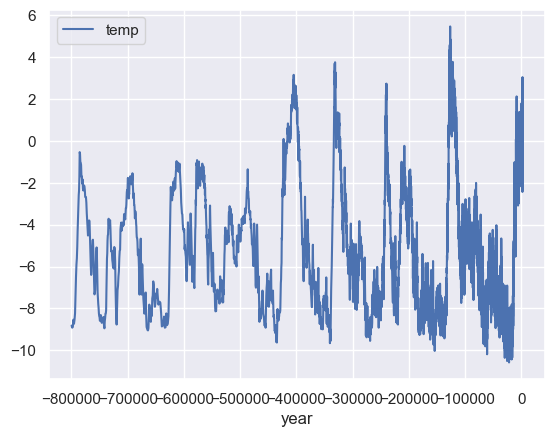

In [23]:
antarctic_temp_df.set_index("year", inplace=True)
antarctic_temp_df.plot()

Extract temperature data from NOAA EDC3 2007 and convert into a DataFrame dasfasdffds change

In [5]:
antarctic_carbon_dioxide_df = pd.read_excel(
    "./data/CO2/grl52461-sup-0003-supplementary.xls",
    sheet_name="CO2 Composite",
    skiprows=14,
)

# Transforming the Antarctic CO2 DataFrame
antarctic_carbon_dioxide_df.drop(["sigma mean CO2 (ppmv)"], axis=1, inplace=True)
antarctic_carbon_dioxide_df["year"] = present_year - antarctic_carbon_dioxide_df[
    "Gasage (yr BP) "
].astype(int)
antarctic_carbon_dioxide_df.rename(columns={"CO2 (ppmv)": "CO2"}, inplace=True)
antarctic_carbon_dioxide_df.drop(["Gasage (yr BP) "], axis=1, inplace=True)

Extract temperature data from NOAA EDC3 2007 and convert into a DataFrame dasfasdffds change

In [6]:
antarctic_methane_df = pd.read_csv(
    "./data/CH4/Nehrbass-Ahles-etal_2020_CH4_comp.tab", skiprows=22, sep="\t"
)

# Transforming the Antarctic CO2 DataFrame
antarctic_methane_df.drop(
    ["Depth ice/snow [m] (average depth)", "Uncertainty [±]", "CH4 [ppbv]"],
    axis=1,
    inplace=True,
)
antarctic_methane_df["year"] = present_year - antarctic_methane_df[
    "Age [ka BP]"
].astype(int)
antarctic_methane_df.rename(
    columns={"CH4 [ppbv] (corrected for gravitational s...)": "CH4"}, inplace=True
)
antarctic_methane_df.drop(["Age [ka BP]"], axis=1, inplace=True)

<Axes: xlabel='year'>

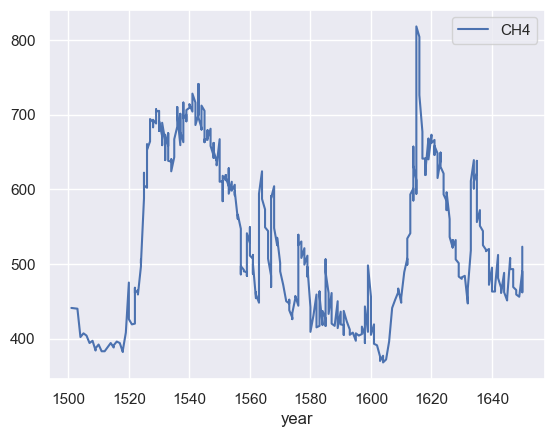

In [21]:
antarctic_methane_df.set_index("year", inplace=True)
antarctic_methane_df.plot()

Making the year a int range as it impossible to use date.time or period on a time period this length. Cannot resample either as it valid with DatetimeIndex, TimedeltaIndex or PeriodIndex.

In [7]:
antarctic_carbon_dioxide_df = antarctic_carbon_dioxide_df.drop_duplicates(subset="year")

min_year = antarctic_carbon_dioxide_df["year"].min()
max_year = antarctic_carbon_dioxide_df["year"].max()
year_range = pd.Series(range(min_year, max_year + 1), name="year")

<Axes: xlabel='year'>

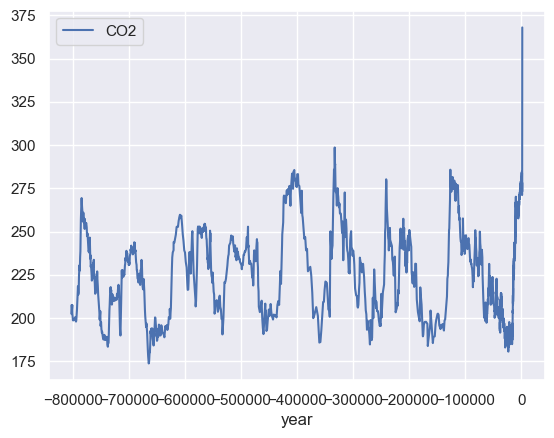

In [22]:
antarctic_carbon_dioxide_df.set_index("year", inplace=True)
antarctic_carbon_dioxide_df.plot()

Adding the year as a new column to Antarctic Temperature DataFrame, Antarctic Carbon Dioxide DataFrame, & Antarctic Methane DataFrame.

In [8]:
antarctic_df = antarctic_carbon_dioxide_df.set_index("year").reindex(year_range)

In [9]:
antarctic_df = pd.merge(antarctic_df, antarctic_temp_df, on="year", how="left")
antarctic_df = pd.merge(antarctic_df, antarctic_methane_df, on="year", how="left")
antarctic_df.set_index("year", inplace=True)

In [10]:
antarctic_df

,CO2,temp,CH4
year,,,
-803718,207.285440,NaN,NaN
-803717,NaN,NaN,NaN
-803716,NaN,NaN,NaN
-803715,NaN,NaN,NaN
-803714,NaN,NaN,NaN
...,...,...,...
1997,NaN,NaN,NaN
1998,361.780737,NaN,NaN
1999,NaN,NaN,NaN


In [19]:
antarctic_temp_df

,temp,year
0,0.88,1912
1,1.84,1904
2,3.04,1895
3,0.35,1886
4,-0.42,1877
...,...,...
5780,-8.73,-795458
5781,-8.54,-796493
5782,-8.88,-797551
5783,-8.92,-798639


<Axes: >

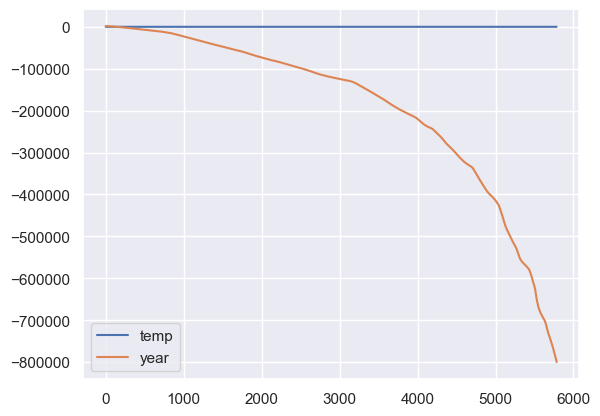

In [18]:
antarctic_temp_df.plot()

In [25]:
antarctic_df.dropna()
antarctic_df["temp"]

year
-803718   NaN
-803717   NaN
-803716   NaN
-803715   NaN
-803714   NaN
           ..
 1997     NaN
 1998     NaN
 1999     NaN
 2000     NaN
 2001     NaN
Name: temp, Length: 805990, dtype: float64

<Axes: xlabel='year'>

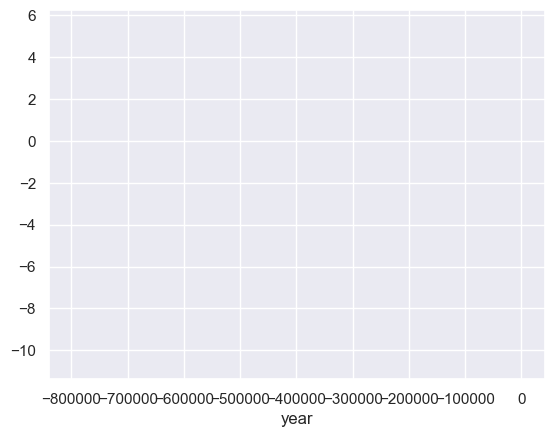

In [17]:
antarctic_df["temp"].plot()

### **Irish Weather Datasets**

Importing, cleaning, and transforming the Irish temperature weather data.

In [12]:
irish_weather_df = pd.read_csv(
    "./data/irish/mly2275.csv",
    sep=",",
    skiprows=19,
    usecols=["year", "month", "meant", "rain"],
)

# Transforming the Irish Weather DataFrame
irish_weather_df["year-month"] = irish_weather_df[["year", "month"]].apply(
    lambda row: "-".join(row.values.astype(str)), axis=1
)

In [13]:
irish_weather_df

,year,month,meant,rain,year-month
0,1939,10,10.0,105.5,1939-10
1,1939,11,10.3,251.9,1939-11
2,1939,12,6.0,116.9,1939-12
3,1940,1,5.8,163.8,1940-1
4,1940,2,7.9,179.6,1940-2
...,...,...,...,...,...
1005,2023,7,15.3,170.3,2023-7
1006,2023,8,15.9,177.1,2023-8
1007,2023,9,15.6,189.3,2023-9
1008,2023,10,12.8,253.1,2023-10


In [14]:
# Reading in the csv file
irish_temp_df1 = pd.read_csv(
    "./data/irish/Valentia-Observatory_second-order-station_1883-1909.csv",
    sep=",",
    encoding="ISO-8859-1",
)

# Transforming the dataset
irish_temp_df1.drop(["Max (°F)", "Min (°F)"], axis=1, inplace=True)
irish_temp_df1["meant"] = irish_temp_df1[["Max (°C)", "Min (°C)"]].mean(axis=1)
irish_temp_df1.drop(["Max (°C)", "Min (°C)"], axis=1, inplace=True)
irish_temp_df1.rename(
    columns={"Year": "year", "Month": "month", "Day ": "day"}, inplace=True
)

irish_temp_df1["date"] = pd.to_datetime(
    irish_temp_df1[["year", "month", "day"]], errors="coerce"
)
irish_temp_df1 = irish_temp_df1.drop(["year", "month", "day"], axis=1)
irish_temp_df1.set_index("date", inplace=True)

# Downsample to yearly
resample = irish_temp_df1.resample("Y")
irish_temp_df1 = resample.mean()

# Reading in the csv file
irish_temp_df2 = pd.read_csv(
    "./data/irish/Valentia-Observatory-telegraphic-reporting-station_1850-1920.csv",
    sep=",",
    encoding="ISO-8859-1",
)

# Transforming the dataset
irish_temp_df2.drop(["Max (°F)", "Min (°F)"], axis=1, inplace=True)
irish_temp_df2["meant"] = irish_temp_df2[["Max (°C)", "Min (°C)"]].mean(axis=1)
irish_temp_df2.drop(["Max (°C)", "Min (°C)"], axis=1, inplace=True)
irish_temp_df2.rename(
    columns={"Year": "year", "Month": "month", "Day": "day"}, inplace=True
)
irish_temp_df2["date"] = pd.to_datetime(
    irish_temp_df2[["year", "month", "day"]], errors="coerce"
)
irish_temp_df2 = irish_temp_df2.drop(["year", "month", "day"], axis=1)
irish_temp_df2.set_index("date", inplace=True)

# Downsample to yearly
resample = irish_temp_df2.resample("Y")
irish_temp_df2 = resample.mean()

# Reading in the csv file
irish_temp_df3 = pd.read_csv(
    "./data/irish/Valentia-Observatory-telegraphic-reporting-station_1921-1943.csv",
    sep=",",
    encoding="ISO-8859-1",
)

# Transforming the dataset
irish_temp_df3.drop(
    ["Max at 7h (°F)", "Min at 7h (°F)", "Max at 18h (°F)", "Min at 18h (°F)"],
    axis=1,
    inplace=True,
)
irish_temp_df3["meant"] = irish_temp_df3[
    ["Max at 7h (°C)", "Min at 7h (°C)", "Max at 18h (°C)", "Min at 18h (°C)"]
].mean(axis=1)
irish_temp_df3.drop(
    ["Max at 7h (°C)", "Min at 7h (°C)", "Max at 18h (°C)", "Min at 18h (°C)"],
    axis=1,
    inplace=True,
)
irish_temp_df3.rename(
    columns={"Year": "year", "Month": "month", "Daily": "day"}, inplace=True
)
irish_temp_df3["date"] = pd.to_datetime(
    irish_temp_df3[["year", "month", "day"]], errors="coerce"
)
irish_temp_df3 = irish_temp_df3.drop(["year", "month", "day"], axis=1)
irish_temp_df3.set_index("date", inplace=True)

# Downsample to yearly
resample = irish_temp_df3.resample("Y")
irish_temp_df3 = resample.mean()

# Combining the datasets
irish_temp_df = pd.concat([irish_temp_df1, irish_temp_df2, irish_temp_df3])

In [15]:
irish_temp_df

,meant
date,
1883-12-31,10.238219
1884-12-31,10.658197
1885-12-31,10.090822
1886-12-31,10.127534
1887-12-31,10.343151
...,...
1939-12-31,10.717603
1940-12-31,10.874454
1941-12-31,10.360137


Text Analysis

https://guides.library.upenn.edu/penntdm/python/import_files#:~:text=Importing%20Files%20(Web%20Scraping)&text=The%20get()%20function%20in,it%20in%20a%20Python%20object.

Parsing a text file into a pandas DataFrame

https://codereview.stackexchange.com/questions/257729/parsing-a-text-file-into-a-pandas-

Pandas Timestamp Limitations

https://calmcode.io/til/pandas-timerange.html#:~:text=Since%20pandas%20represents%20timestamps%20in,limited%20to%20approximately%20584%20years.

How To Resample and Interpolate Your Time Series Data With Python

https://machinelearningmastery.com/resample-interpolate-time-series-data-python/

pandas.read_excel

https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html


Compilation of improved CH4 data derived from the European Project for Ice Coring in Antarctica (EPICA) Dome C

https://doi.pangaea.de/10.1594/PANGAEA.914908


An optimized multi-proxy, multi-site Antarctic ice and gas orbital chronology (AICC2012): 120–800 ka

https://cp.copernicus.org/articles/9/1715/2013/


How to concatenate multiple column values into a single column in Pandas dataframe

https://stackoverflow.com/questions/39291499/how-to-concatenate-multiple-column-values-into-a-single-column-in-pandas-datafra

***
# End